<a href="https://colab.research.google.com/github/itzchav/TensorFlow-Probabilidad-Condicional/blob/main/Probabilidad_Condicional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Librerias Necesarias***

*Library*

In [ ]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split



### ***Cargar Archivos***

*Load dataset*

Ejemplo (Example):


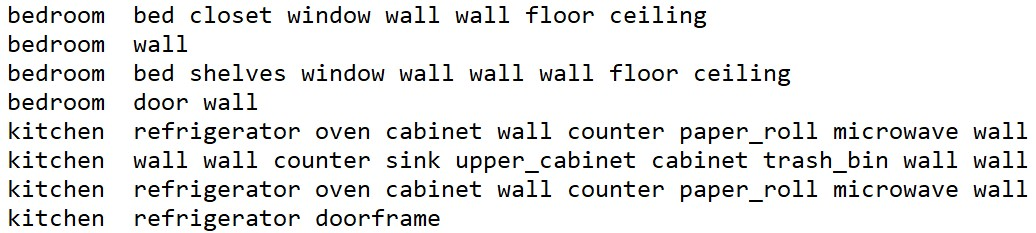

In [ ]:
dataframe = pd.read_csv("Archivos_limpios.txt", sep='\t',header=None)
dataset = dataframe.values
dataframe

,0,1
0,bathroom,window towel paper_roll toilet toilet_brush p...
1,bathroom,towel bath faucet bottle bottle bottle wall w...
2,bathroom,faucet teddy_pumba tooth_brush_holder sink mi...
3,bathroom,window towel paper_roll toilet toilet_brush p...
4,bathroom,towel bath faucet bottle bottle bottle wall w...
...,...,...
10715,kitchen,picture picture bottle plant washing_machine ...
10716,kitchen,chair table bottle refrigerator upper_cabinet...
10717,kitchen,picture numeric_pattern stool chair chair fru...
10718,kitchen,picture clock picture baby_chair washing_mach...


### ***Formato del DataFrame***
***DataFrame Format***


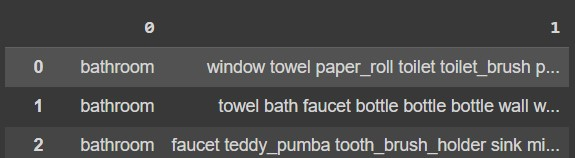

### ***Preprocesamiento de Datos***

#### *Empleando la funcion: "train_test_split", se mezcla de forma aleatoria los elementos del archivo dividiendo el total en 75% para entrenamiento y el 25% para prueba*

#### *Posteriormente se dividen las etiquetas y los objetos, en distintos vectores*

***Data preprocessing***


*Using the function: "train_test_split" the elements of the file are randomly mixed, dividing the total into 75% for training and 25% for testing*


*Subsequently, the labels and objects are divided into different vectors*



In [ ]:

train, test = train_test_split(dataset, random_state = 0)

train_X = train[:,1]
train_Y = train[:,0]
test_X = test[:,1]
test_y = test[:,0]
print(train_Y[20],train_X[20])
print(train_Y[61],train_X[61])
print(train_Y[2],train_X[2])


bathroom  bath wall                      
bedroom  closet                           
kitchen  fruit_bowl curtain picture chair chair fruit_bowl apple plate table sink fruit_bowl cereal_box bowl stove pot microwave upper_cabinet shelves smoke_extractor upper_cabinet counter cabinet oven cabinet wall wall wall wall floor paper_roll ceiling         


### ***Procesameinto de las etiquetas***

***Label processing***

In [ ]:
#For Training Elements

# encode class values as integers
## codificar valores de clase como enteros
encoder = LabelEncoder()
encoder.fit(train_Y)
encoded_Y = encoder.transform(train_Y)


# convert integers to dummy variables 
#convertir enteros en variables ficticias 
dummy_trainy = np_utils.to_categorical(encoded_Y)
dummy_trainy



array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [ ]:

#For Test Elements
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(test_y)
encoded_Y = encoder.transform(test_y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_testy = np_utils.to_categorical(encoded_Y)
dummy_testy


array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

### ***Procesamiento de Datos***

*Se debe crear una función de estandarización personalizada.*

***Data Processing***

*A custom standardization function must be created.*

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

#### *Posteriormente se puede instanciar la capa de vectorización de texto.*

#### *Esta capa se emplea para normalizar, dividir y asignar cadenas a números enteros.*

*Later the text vectorization layer can be instantiated.*

*This layer is used to normalize, divide, and map strings to integers.*

In [ ]:
max_caracteristicas = 1000
sequence_length = 500

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_caracteristicas,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
vectorize_layer.adapt(train_X)
vectorize_layer.adapt(test_X)

In [ ]:
def vectorize_text(text, label):
  texto = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
train_=vectorize_text(train_X, dummy_trainy)
tr_X=train_[0]
tr_Y=train_[1]

In [ ]:
test_=vectorize_text(test_X, dummy_testy)
te_X=[a[0] for a in test_]
te_Y=[a[1] for a in test_]

### ***Contruyendo el Modelo***

#### *Se ingresan tres capas de salida y se emplea Softmax debido a que:*

#### *Convierte los datos en probabilidades.*

#### *La suma de las probabilidades tiene como resultado  1.*

#### *Se compila el modelo con pérdida de entropía cruzada binaria y un optimizador Adam.*


***Build a model***

*Three output layers are entered and Softmax is used because it converts the data to probability.*

*The sum of the probabilities results in 1.*

*The model is compiled with binary cross-entropy loss and an Adam optimizer.*

In [ ]:
embedding_dim = 16

modelo = tf.keras.Sequential([
  layers.Embedding(max_caracteristicas + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(3,activation=tf.nn.softmax)])  
modelo.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          16016     
                                                                 
 dropout_4 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 16,067
Trainable params: 16,067
Non-trainable params: 0
__________________________________________________

In [ ]:
modelo.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

###***Entrenando el Modelo***

***Train the model***

In [ ]:
epocas = 100
history = modelo.fit(
    tr_X,
    tr_Y,
    validation_data=test_,
    epochs=epocas
    )

Epoch 1/100
252/252 [==============================] - 3s 8ms/step - loss: 0.7563 - binary_accuracy: 0.3333 - val_loss: 0.7507 - val_binary_accuracy: 0.3333
Epoch 2/100
252/252 [==============================] - 2s 9ms/step - loss: 0.7501 - binary_accuracy: 0.3333 - val_loss: 0.7483 - val_binary_accuracy: 0.3333
Epoch 3/100
252/252 [==============================] - 2s 10ms/step - loss: 0.7484 - binary_accuracy: 0.3333 - val_loss: 0.7467 - val_binary_accuracy: 0.3333
Epoch 4/100
252/252 [==============================] - 2s 8ms/step - loss: 0.7465 - binary_accuracy: 0.3333 - val_loss: 0.7444 - val_binary_accuracy: 0.3333
Epoch 5/100
252/252 [==============================] - 2s 8ms/step - loss: 0.7435 - binary_accuracy: 0.3333 - val_loss: 0.7406 - val_binary_accuracy: 0.3333
Epoch 6/100
252/252 [==============================] - 2s 8ms/step - loss: 0.7387 - binary_accuracy: 0.3333 - val_loss: 0.7353 - val_binary_accuracy: 0.3333
Epoch 7/100
252/252 [==============================] - 2s

In [ ]:
historial_dict = history.history
historial_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

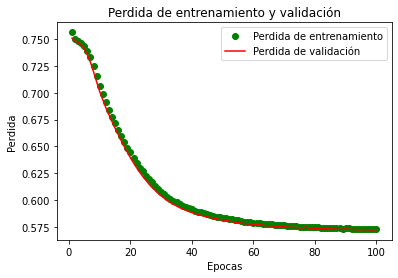

In [ ]:
acc = historial_dict['binary_accuracy']
val_acc = historial_dict['val_binary_accuracy']
perdida = historial_dict['loss']
val_perdida = historial_dict['val_loss']

epocas = range(1, len(acc) + 1)

plt.plot(epocas, perdida, 'go', label='Perdida de entrenamiento')

plt.plot(epocas, val_perdida, 'r', label='Perdida de validación')
plt.title('Perdida de entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('Perdida')
plt.legend()

plt.show()

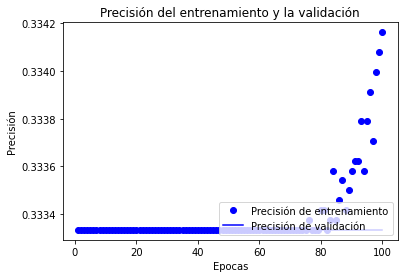

In [ ]:
plt.plot(epocas, acc, 'bo', label='Precisión de entrenamiento')
plt.plot(epocas, val_acc, 'b', label='Precisión de validación')
plt.title('Precisión del entrenamiento y la validación')
plt.xlabel('Epocas')
plt.ylabel('Precisión')
plt.legend(loc='lower right')

plt.show()

In [ ]:
print("Bedroom",dummy_trainy[20])
print(tr_X[20,:20])
print(train_Y[20],train_X[20])
print("Bathroom",dummy_trainy[61])
print(tr_X[61,:20])
print(train_Y[61],train_X[61])
print("Kitchen",dummy_trainy[2])
print(train_Y[2],train_X[2])
print(tr_X[2,:20])

Bedroom [1. 0. 0.]
tf.Tensor([26  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
bathroom  bath wall                      
Bathroom [0. 1. 0.]
tf.Tensor([13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
bedroom  closet                           
Kitchen [0. 0. 1.]
kitchen  fruit_bowl curtain picture chair chair fruit_bowl apple plate table sink fruit_bowl cereal_box bowl stove pot microwave upper_cabinet shelves smoke_extractor upper_cabinet counter cabinet oven cabinet wall wall wall wall floor paper_roll ceiling         
tf.Tensor(
[ 28  10   4  16  16  28 115 100  15  18  28  69  49  31  41  35   7   6
  25   7], shape=(20,), dtype=int64)


In [192]:
Xnew = [[24,64,46,43],[9,18,38,27],[5,10,7,26]]
ynew = modelo.predict(Xnew)
# show the inputs and predicted outputs
for i in range(len(Xnew)):
	print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))

X=[24, 64, 46, 43], Predicted=[1. 0. 0.]
X=[9, 18, 38, 27], Predicted=[0. 1. 0.]
X=[5, 10, 7, 26], Predicted=[0. 0. 1.]
